In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [13]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')


fourier_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_mask.npy')

In [ ]:
def special_spectrum_1D(y):
    import numpy as np    
    
    if y.ndim == 1:
        ################
        # multiplying by 2 because the gridpoints are each separated by 2km
        lengths_loc = 2*np.arange(0,len(y))
        ################

        fourier = np.fft.fft(y, norm='ortho')
        
        # multiply by 2\pi to obtain wavenumbers
        wvnmr = (2*np.pi)*np.fft.fftfreq(lengths_loc.size, d=np.diff(lengths_loc)[0])

        return wvnmr, np.abs(fourier)
    else:
        print('y seems not to be 1D, check!')


def print_monthly_spectrum_1D(y, title, distance=False):
    monthly_spectra_collector_lon = np.zeros((29, int(y[0,0].size), int(y[0,0].size)))
    monthly_spectra_collector_lat = np.zeros_like(monthly_spectra_collector_lon)
    wvnmr = np.zeros_like(monthly_spectra_collector_lon[0,0])

    for t in range(29):
        for i in range(y[t,0].size):
            yy = y[t, :, i] - np.nanmean(y[t, :, i])
            trash, monthly_spectra_collector_lon[t, i] = special_spectrum_1D(yy)

            yy = y[t, i, :] - np.nanmean(y[t, i, :])
            trash, monthly_spectra_collector_lat[t, i] = special_spectrum_1D(yy)

        if t == 1:
            # wvnmr are common for every spectrum, so I just save it once
            wvnmr = trash
            
    mean_monthly_spectrum_lon = np.mean(monthly_spectra_collector_lon, axis=(0,1))
    mean_monthly_spectrum_lat = np.mean(monthly_spectra_collector_lat, axis=(0,1))

    std_month_spectra_lon = np.std(monthly_spectra_collector_lon, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
    std_month_spectra_lat = np.std(monthly_spectra_collector_lat, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))

    if distance:
        plt.loglog(2*np.pi/wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], '.-', label='long')
        plt.loglog(2*np.pi/wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], '.-', label='lat')
        plt.xlabel(r'scales [$km$]', fontsize=14)
        
    else:
        plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], '.-', label='long')
        plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], '.-', label='lat')
        plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
    
    plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
    plt.title('monthly mean 1D spectra of '+title, fontsize=14)
    plt.legend()

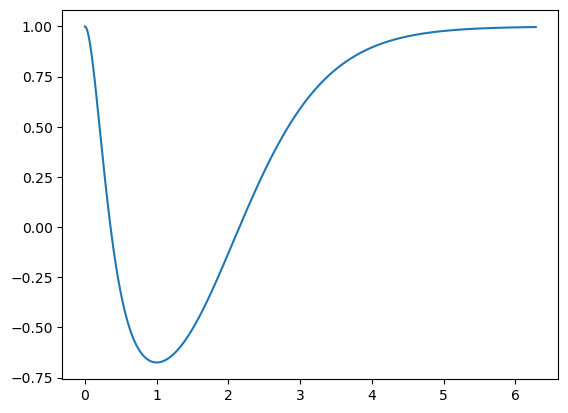

In [5]:
duration = 2*np.pi
start = 0 #-np.pi
sf = 1000        # sampling frequency

sigma = 1
a = 0
x = np.linspace(start+a, start+duration+a, int(sf*duration), endpoint=True)
y = np.cos(2*np.pi*x*np.exp(-sigma*x))  #(1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-(((x-a)/sigma)**2))

plt.plot(x, y)

(-20.0, 20.0)

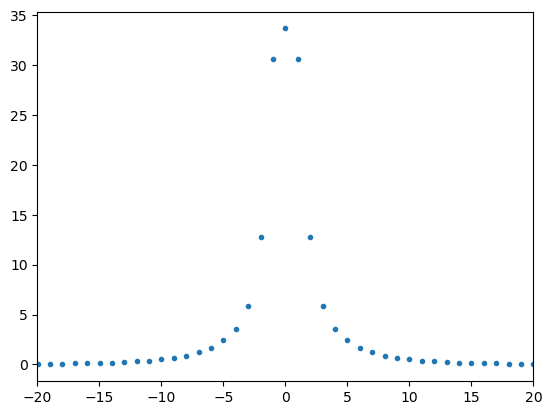

In [6]:
fourier = np.fft.fft(y, norm='ortho')
freq = 2*np.pi*np.fft.fftfreq(x.size, d=np.diff(x)[0])

strength = np.abs(fourier)

plt.plot(freq, strength, '.')
plt.xlim([-20, 20])

In [14]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day'].values*fourier_mask   

# dsst_day = dsst_day.reshape(29, 273, 273)

In [11]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_mask.npy', [fourier_1])

creating new file and saving variables


In [15]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst = sst.where(sea_mask_modified, drop=False)
lon, lat = sst.nav_lon, sst.nav_lat

sst_day = sst.groupby('time_counter.day').mean()
sst_day = sst_day.values*fourier_mask   
# sst_day = sst_day.reshape(29, 273, 273)

(29, 546, 573)

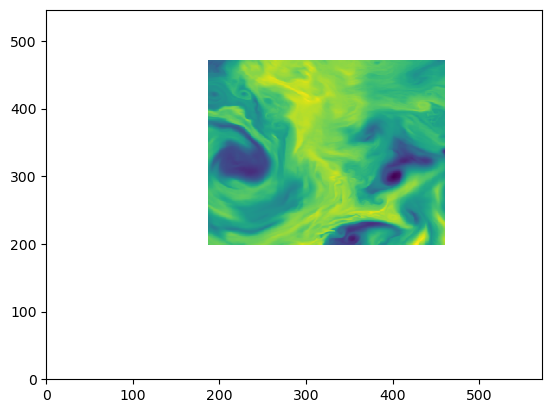

In [17]:
plt.pcolormesh(sst_day[0])

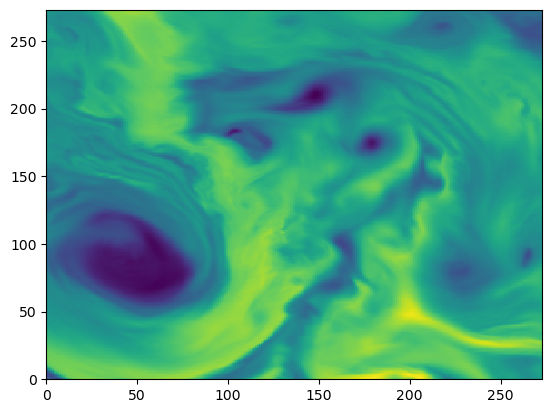

In [19]:
sst_spectr = sst_day[~np.isnan(sst_day)]
sst_spectr = sst_spectr.reshape(29, 273, 273)

plt.pcolormesh(sst_spectr[10])

# 1D spectra over longitude / latitude

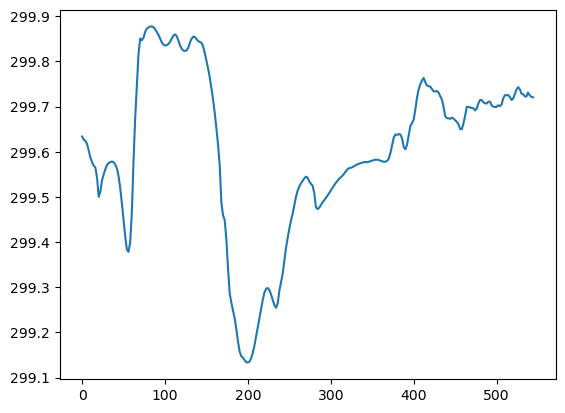

In [47]:
sst_1d = sst_day[0, :, 210]
lengths = 2*np.arange(0,len(sst_1d))
plt.plot(lengths, sst_1d)

Text(0.5, 1.0, '1D spectrum of SST anomalies at given longitude')

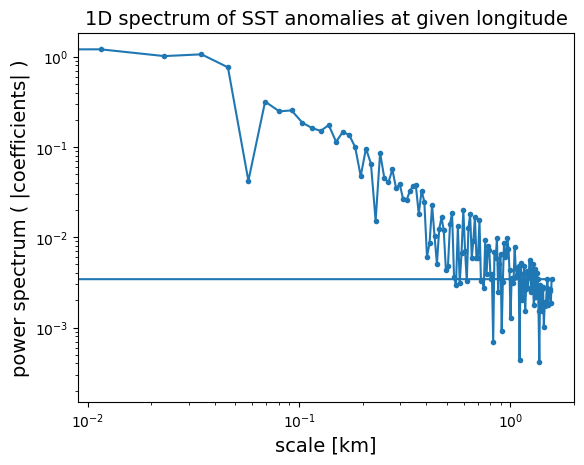

In [55]:
fourier = np.fft.fft(sst_1d-np.mean(sst_1d), norm='ortho')
freq = 2*np.pi*np.fft.fftfreq(lengths.size, d=np.diff(lengths)[0])
# freq_shift = np.fft.fftshift(freq)

strength = np.abs(fourier)

plt.loglog(freq[:freq.size//2], strength[:strength.size//2], '.-')
plt.xlabel('scale [km]', fontsize=14)
plt.ylabel('power spectrum ( |coefficients| )', fontsize=14)
plt.title('1D spectrum of SST anomalies at given longitude', fontsize=14)





## instantaneous

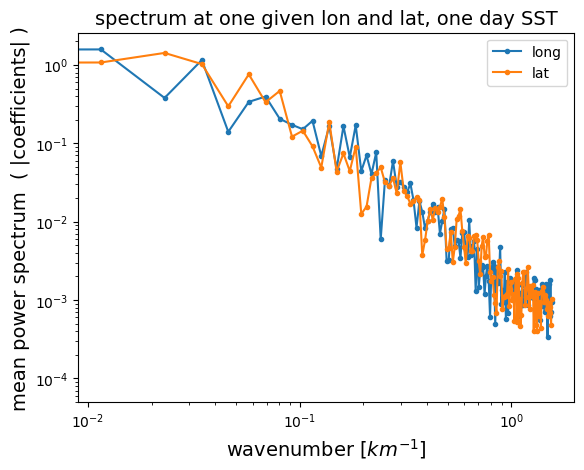

In [24]:
lon_level, lat_level = 50, 100
yy = sst_day[0, :, lon_level] - np.nanmean(sst_day[0, :, lon_level])
trash, spectra_lon = special_spectrum_1D(yy)

yy = sst_day[0, lat_level, :] - np.nanmean(sst_day[0, lat_level, :])
trash, spectra_lat = special_spectrum_1D(yy)


plt.loglog(wvnmr[:wvnmr.size//2], spectra_lon[:spectra_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], spectra_lat[:spectra_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('spectrum at one given lon and lat, one day SST', fontsize=14)
plt.legend()

### mean of 1 day

In [32]:
spectra_collector_lon = np.zeros((int(sst_day[0,0].size), int(sst_day[0,0].size)))
spectra_collector_lat = np.zeros_like(spectra_collector_lon)
wvnmr = np.zeros_like(spectra_collector_lon[0])

for i in range(sst_day[0,0].size):
    yy = sst_day[10, :, i] - np.nanmean(sst_day[10, :, i])
    trash, spectra_collector_lon[i] = special_spectrum_1D(yy)
    
    yy = sst_day[10, i, :] - np.nanmean(sst_day[10, i, :])
    trash, spectra_collector_lat[i] = special_spectrum_1D(yy)
    
    if i == 1:
        # wvnmr are common for every spectrum, so I just save it once
        wvnmr = trash

In [31]:
spectra_collector_lon.shape

(273, 273)

In [87]:
wvnmr.shape

(273,)

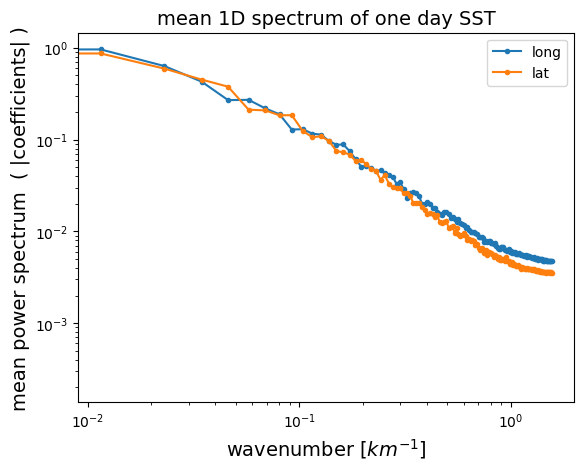

In [34]:
mean_spectrum_lon = np.mean(spectra_collector_lon, axis=0)
std_spectra_lon = np.std(spectra_collector_lon, axis=1)/(np.sqrt(mean_spectrum_lon.size))

mean_spectrum_lat = np.mean(spectra_collector_lat, axis=0)
std_spectra_lat = np.std(spectra_collector_lat, axis=1)/(np.sqrt(mean_spectrum_lat.size))

# plt.errorbar(wvnmr[:wvnmr.size//2], mean_spectrum_lon[:mean_spectrum_lon.size//2], yerr=std_spectra_lon[:std_spectra_lon.size//2], label='long')
# plt.errorbar(wvnmr[:wvnmr.size//2], mean_spectrum_lat[:mean_spectrum_lat.size//2], yerr=std_spectra_lat[:std_spectra_lat.size//2], label='lat')

plt.loglog(wvnmr[:wvnmr.size//2], mean_spectrum_lon[:mean_spectrum_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], mean_spectrum_lat[:mean_spectrum_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('mean 1D spectrum of one day SST', fontsize=14)
plt.legend()

### monthly mean of spectra

In [28]:
monthly_spectra_collector_lon = np.zeros((29, int(sst_day[0,0].size), int(sst_day[0,0].size)))
monthly_spectra_collector_lat = np.zeros_like(monthly_spectra_collector_lon)
wvnmr = np.zeros_like(monthly_spectra_collector_lon[0,0])

for t in range(29):
    for i in range(sst_day[t,0].size):
        yy = sst_day[t, :, i] - np.nanmean(sst_day[t, :, i])
        trash, monthly_spectra_collector_lon[t, i] = special_spectrum_1D(yy)
        
        yy = sst_day[t, i, :] - np.nanmean(sst_day[t, i, :])
        trash, monthly_spectra_collector_lat[t, i] = special_spectrum_1D(yy)
        
    if t == 1:
        # wvnmr are common for every spectrum, so I just save it once
        wvnmr = trash

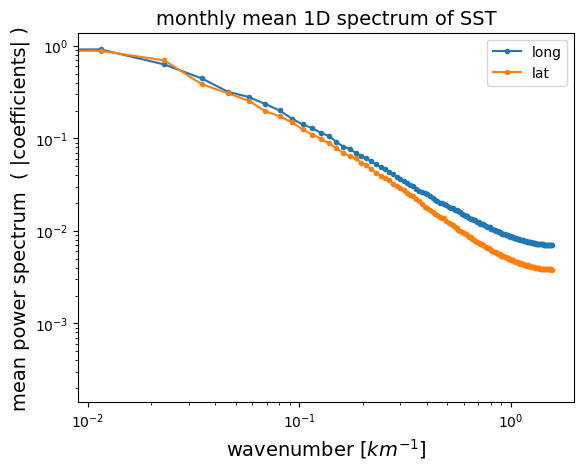

In [29]:
mean_monthly_spectrum_lon = np.mean(monthly_spectra_collector_lon, axis=(0,1))
mean_monthly_spectrum_lat = np.mean(monthly_spectra_collector_lat, axis=(0,1))

std_month_spectra_lon = np.std(monthly_spectra_collector_lon, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
std_month_spectra_lat = np.std(monthly_spectra_collector_lat, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))


# plt.errorbar(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], yerr=std_month_spectra_lon[:std_month_spectra_lon.size//2])
# plt.errorbar(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], yerr=std_month_spectra_lat[:std_month_spectra_lat.size//2])

plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('monthly mean 1D spectra of SST', fontsize=14)
plt.legend()

## testing my function for plotting fourier spectra averaged over the whole month

In [24]:
type(sst_spectr)

numpy.ndarray

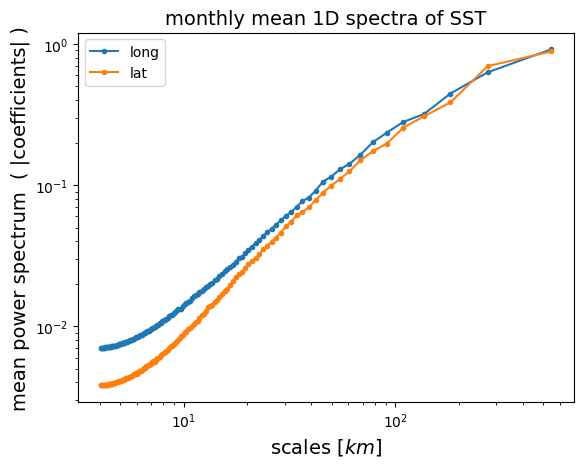

In [26]:
y = sst_spectr
title = 'SST'
print_monthly_spectrum_1D(y, title, distance=True)

# 2D case - A very dirty try

In [10]:
dsst_spectr = np.fft.fft2(dsst_day[0], norm='ortho')
dsst_spectr_ampl = np.abs(dsst_spectr)
dsst_spectr_phase = np.angle(dsst_spectr)

# shift the zero-frequency component at the centre of the spectrum
dsst_spectr_centred = np.fft.fftshift(dsst_spectr)
dsst_spectr_centr_ampl = np.abs(dsst_spectr_centred)
dsst_spectr_centr_phase = np.angle(dsst_spectr_centred)

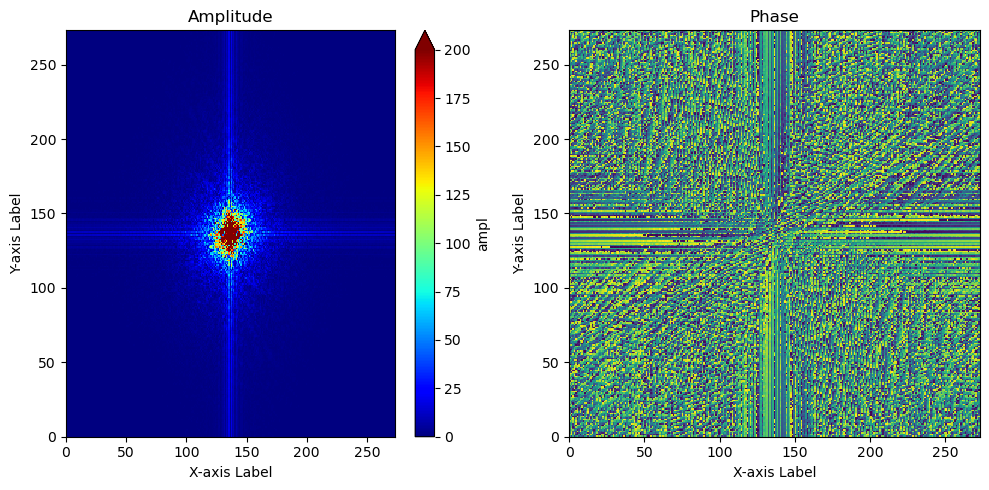

In [11]:

# Create a figure and 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot (left)
im = axes[0].pcolormesh(dsst_spectr_centr_ampl, vmin=0, vmax=200, cmap='jet')
cbar = plt.colorbar(im, ax=axes[0], extend='max')
cbar.set_label('ampl')

axes[0].set_title('Amplitude')
axes[0].set_xlabel('X-axis Label')
axes[0].set_ylabel('Y-axis Label')

# Second subplot (right)
axes[1].pcolormesh(dsst_spectr_centr_phase)
axes[1].set_title('Phase')
axes[1].set_xlabel('X-axis Label')
axes[1].set_ylabel('Y-axis Label')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
npix = len(dsst_day[0].flatten())
npix

74529

https://stackoverflow.com/questions/66977714/generating-new-2d-data-using-power-spectrum-density-function-from-spatial-freque

https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

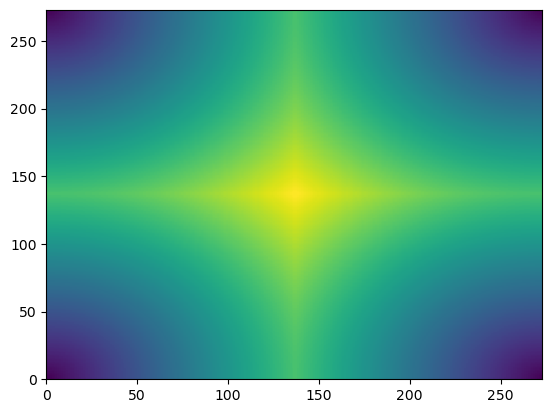

In [70]:
plt.pcolormesh(knrm_mesh)

In [74]:
npix

273

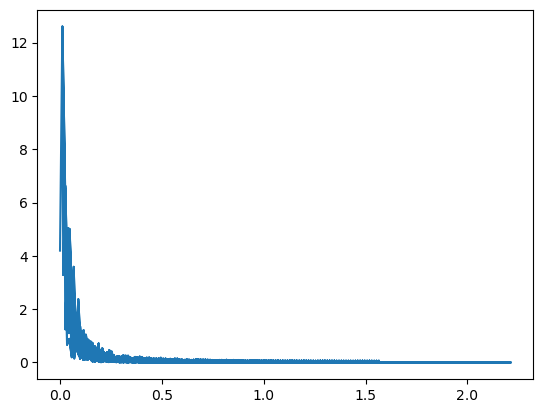

In [76]:
fourier_image = np.fft.fft2(dsst_day[0], norm='ortho')
#fourier_image = np.fft.fftshift(fourier_image)
fourier_amplitudes = np.abs(fourier_image)

npix = len(dsst_day[0])

kfreq = 2*np.pi*np.fft.fftfreq(npix, d=2000)  # *npix   # 2 km
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm_mesh = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()


kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

plt.plot(Abins)


plt.plot(knrm, fourier_amplitudes)
plt.show()

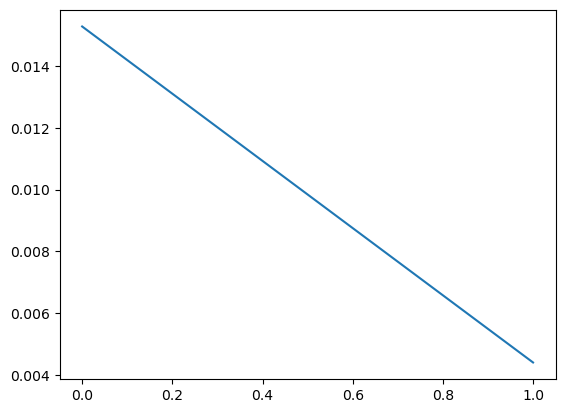

In [77]:
kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

plt.plot(Abins)

# try another approach: first do the fft along y, and then x

In [109]:
fourier_lat = np.fft.fft(sst_day[0], axis=0, norm='ortho')
wvnmr_lat = 2*np.pi*np.fft.fftfreq(sst_day[0,:,0].size, d=2)
fourier_lat = fourier_lat.reshape(273,273)

In [110]:
fourier_lat_lon = np.fft.fft(fourier_lat, axis=1, norm='ortho')
wvnmr_lon = wvnmr_lat

In [114]:
wvnmr_lon, wvnmr_lat = np.meshgrid(wvnmr_lon, wvnmr_lat)
wvnmr = np.sqrt(wvnmr_lon**2+wvnmr_lat**2)

In [115]:
strength = np.abs(fourier_lat_lon)

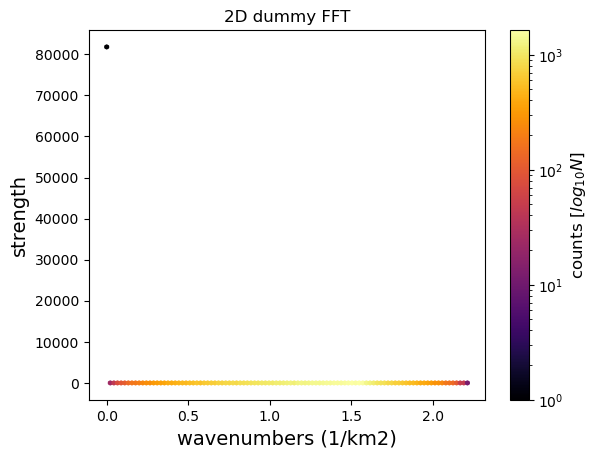

In [117]:
title = '2D dummy FFT'
xlabel = 'wavenumbers (1/km)'
ylabel = 'strength'

pos = [0.9, 0.9]

density_hexbin(wvnmr, strength, plot_fit = False, fit=None, corcoe=None, grdsz=100, title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)


# NO

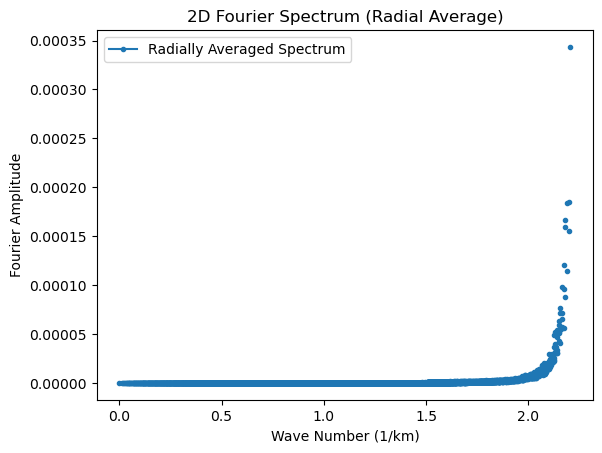

In [87]:
## CORRETTO DA CHATGPT, INFATTI NON FUNZIONA


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Perform 2D Fourier transform of the image with normalization
fourier_image = np.fft.fft2(dsst_day[0], norm='ortho')
fourier_image = np.fft.fftshift(fourier_image)  # Shift zero frequency component to center
fourier_amplitudes = np.abs(fourier_image)

# Define the number of pixels in one dimension of the image
npix = dsst_day[0].shape[0]

# Define the frequency array based on spatial resolution (2 km in this case)
kfreq = np.fft.fftfreq(npix, d=2)  # 2 km per pixel spatial resolution
kfreq = 2 * np.pi * kfreq  # Convert to angular frequency (radians per km)

# Create 2D frequency grid
kfreq_x, kfreq_y = np.meshgrid(kfreq, kfreq)
knrm_mesh = np.sqrt(kfreq_x**2 + kfreq_y**2)

# Flatten the arrays for binning
knrm = knrm_mesh.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

# Define the radial bins for averaging
kbins = np.arange(0.0, knrm.max(), 2 * np.pi / (npix * 2000))  # set bin width for radial averaging
kvals = 0.5 * (kbins[1:] + kbins[:-1])

# Calculate the mean Fourier amplitude in each radial bin
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic="mean",
                                     bins=kbins)

# Adjust for bin area by scaling with radial shell width (if needed for amplitude adjustment)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

# Plot the radially averaged Fourier spectrum
plt.plot(kvals, Abins, '.-', label="Radially Averaged Spectrum")
plt.xlabel("Wave Number (1/km)")
plt.ylabel("Fourier Amplitude")
plt.title("2D Fourier Spectrum (Radial Average)")
plt.legend()
plt.show()
